# Computer Assignment 5
# Image and Video Processing
## Aakaash Jois - N14182682 - aj2309

### Import statements

In [1]:
from contextlib import redirect_stdout
from io import StringIO
from matplotlib import pyplot as plt
from matplotlib.image import imread
from numpy import random, zeros, array, float64, meshgrid, insert, linspace
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

### Functions

#### Load the image from path
* `path`: path to image
* `coordinate_dependency`: Adjust image array to include coordinate components
* `w`: dependency of coordinates on clustering

`return`: image, image dimensions as a tuple, and vectorized image

In [2]:
def load_image(path, 
               coordinate_dependency=False,
               w=0):
    
    image = imread(path)
    image = array(image, dtype=float64) / 255
    if coordinate_dependency:
        x = linspace(0, w * 255 / image.shape[1], image.shape[1])
        y = linspace(0, w * 255 / image.shape[0], image.shape[0])
        _y, _x = meshgrid(x, y)
        image = insert(image, image.shape[2], _x, axis=2)
        image = insert(image, image.shape[2], _y, axis=2)
    w, h, d = tuple(image.shape)
    image_array = image.reshape((w * h, d))
    
    return image, tuple([w, h, d]), image_array

#### Use K-Means or the benchmark clustering algorithm to cluster colors
* `image_array`: vectored image array
* `cluster_algorithm`: algorithm for clustering colors (default: kmeans)
* `n_cluster`: number of colors (default: 8)
* `random_state`: state of the randomizer (default: None)
* `init`: method for selecting initial centroids (default: k-means++)
* `n_init`: number of trials (default: 10)
* `get_inertia`: return the quantization mean square error value (default: False)

`return`: codebook and labels if clustering algorithm is specified else None

In [3]:
def cluster_colors(image_array,
                   cluster_algorithm='kmeans',
                   n_cluster=8,
                   random_state=None,
                   init='k-means++',
                   n_init=10,
                   get_inertia=False):
    
    if cluster_algorithm == 'kmeans':
        image_sample = shuffle(image_array, random_state=random_state)[:1000]
        
        if get_inertia:            
            
            with StringIO() as buffer, redirect_stdout(buffer):
                kmeans = KMeans(n_clusters=n_cluster,
                                init=init,
                                random_state=random_state, 
                                n_init=n_init,
                                verbose=1).fit(image_sample)
                logs = buffer.getvalue()
                inertias = []
                
                for inertia_line in logs.split('\n'):
                    
                    if "inertia " in inertia_line:
                        inertias.append(float(inertia_line.split("inertia ")[1]))
                        
            return kmeans.cluster_centers_, kmeans.predict(image_array), inertias
        
        else:      
            kmeans = KMeans(n_clusters=n_cluster,
                            init=init,
                            random_state=random_state,
                            n_init=n_init).fit(image_sample)
            
            return kmeans.cluster_centers_, kmeans.predict(image_array)
        
    elif cluster_algorithm == 'benchmark':
        codebook_random = shuffle(image_array, random_state=random_state)[:n_cluster + 1]
        labels = pairwise_distances_argmin(codebook_random, image_array, axis=0)
        
        return codebook_random, labels
    
    else:
        return None

#### Recreate the (compressed) image from the code book & labels
* `codebook`: codebook obtained from clustering algorithm
* `labels`: labels obtained from clustering algorithm
* `w`: width of the image
* `h`: height of the image

`return`: reconstructed image

In [4]:
def recreate_image(codebook,
                   labels,
                   w,
                   h):
    
    d = codebook.shape[1]
    image = zeros((w, h, d))
    label_index = 0
    
    for i in range(w):
        for j in range(h):
            image[i, j] = codebook[labels[label_index]]
            label_index += 1
            
    return image

## Problem 1

#### Loading the image

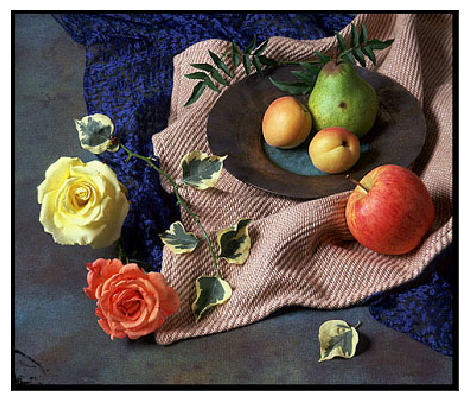

In [5]:
image, (w, h, d), image_array = load_image('Fruit.jpg')
plt.figure(figsize=(13, 7))
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

Let us consider the image above as the test image. It is an image of shape of `321x377x3`.

#### Clustering with 64 colors using K-Means and benchmark algorithm

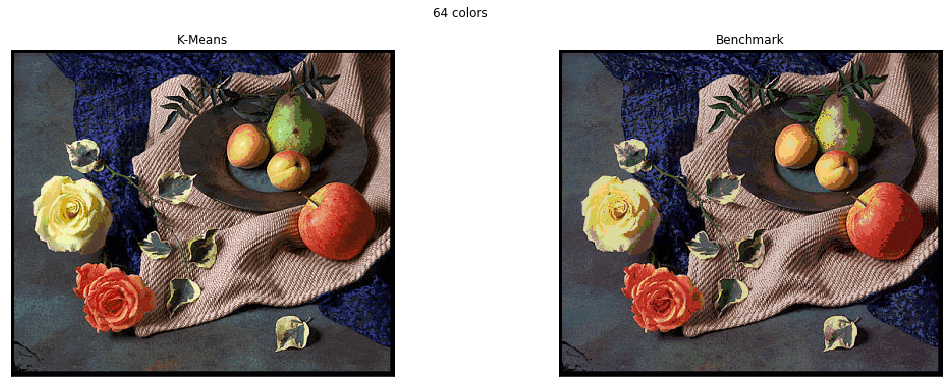

In [6]:
codebook_k_64, labels_k_64 = cluster_colors(image_array, 'kmeans', 64)
recreated_image_k_64 = recreate_image(codebook_k_64, labels_k_64, w, h)
codebook_b_64, labels_b_64 = cluster_colors(image_array, 'benchmark', 64)
recreated_image_b_64 = recreate_image(codebook_b_64, labels_b_64, w, h)
plt.figure(figsize=(18, 6))
plt.suptitle('64 colors')
plt.subplot(1, 2, 1)
plt.imshow(recreated_image_k_64)
plt.xticks([])
plt.yticks([])
plt.title('K-Means')
plt.subplot(1, 2, 2)
plt.imshow(recreated_image_b_64)
plt.xticks([])
plt.yticks([])
plt.title('Benchmark')
plt.show()

We can observe the K means clustering algorithm is able to give a better representation of the original image. The petals of the roses have less noise and more accurate color description when comparing with the benchmarking algoritm. We can also observe the step between each color in the benchmark algorithm, especially in the fruits, which is not so prominent in the K means clustering algorithm.

#### Clustering with 256 colors using K-Means and benchmark algorithm

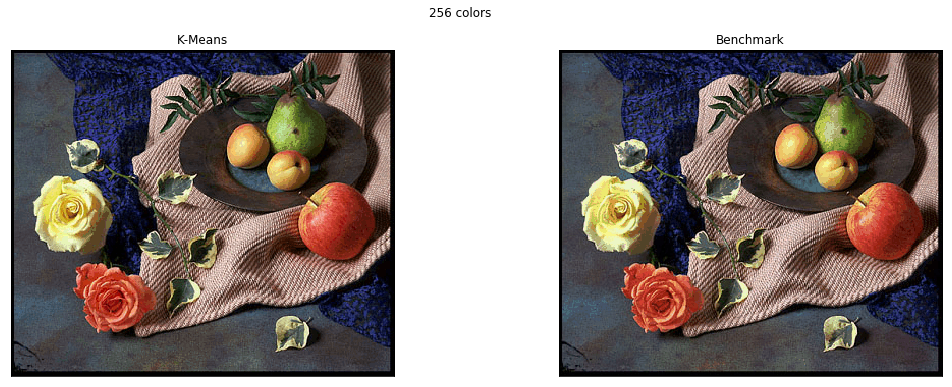

In [7]:
codebook_k_256, labels_k_256 = cluster_colors(image_array, 'kmeans', 256)
recreated_image_k_256 = recreate_image(codebook_k_256, labels_k_256, w, h)
codebook_b_256, labels_b_256 = cluster_colors(image_array, 'benchmark', 256)
recreated_image_b_256 = recreate_image(codebook_b_256, labels_b_256, w, h)
plt.figure(figsize=(18, 6))
plt.tight_layout()
plt.suptitle('256 colors')
plt.subplot(1, 2, 1)
plt.imshow(recreated_image_k_256)
plt.xticks([])
plt.yticks([])
plt.title('K-Means')
plt.subplot(1, 2, 2)
plt.imshow(recreated_image_b_256)
plt.xticks([])
plt.yticks([])
plt.title('Benchmark')
plt.show()

The differences of K-Means and benchmark algorithm are more prominent when clustering with 256 colors. K-Means clustering algorithm is able recreate the complete image with just 256 colors to a point where it is almost indistunguishable when comparing the test image and the recreated image. However, we observe the benchmark does improve the quality from 64 colors to 256 colors, we can still see the drastic change between colors.

#### Obtaining and comparing error vs iteration time for different initilization methods

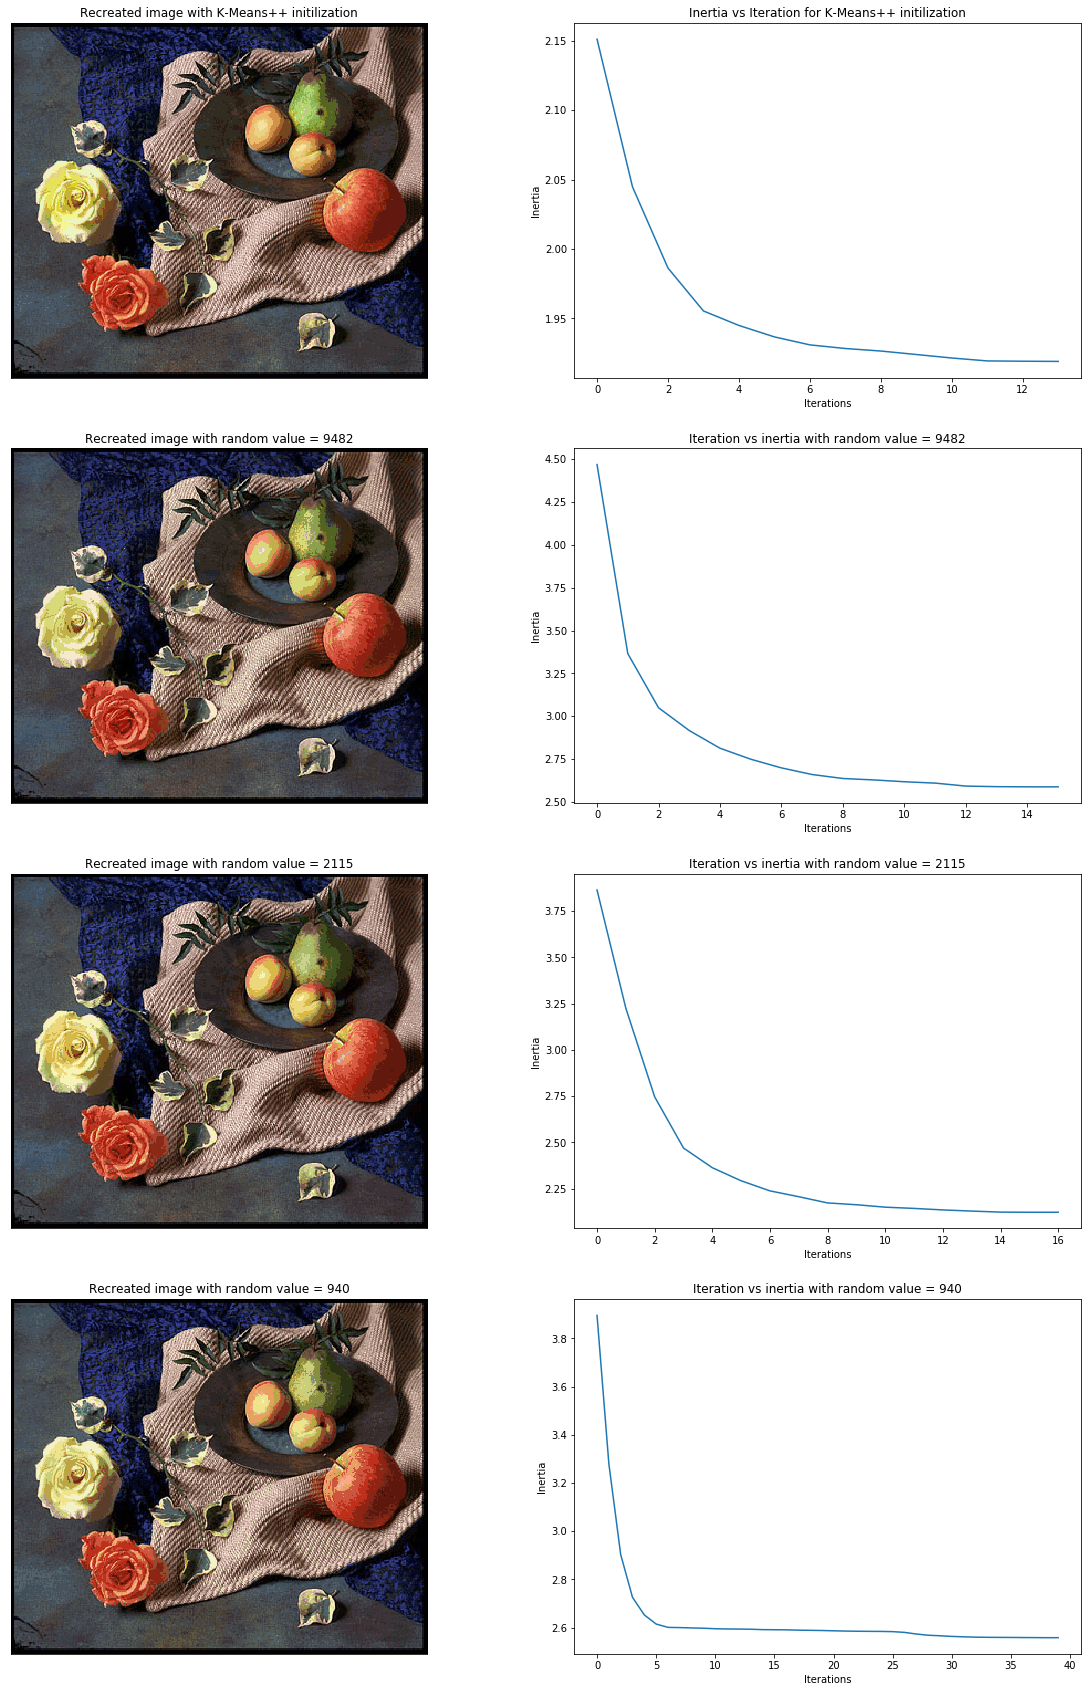

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(20, 30))
codebook_kmeans, labels_kmeans, logs_kmeans = cluster_colors(image_array,
                                                             'kmeans',
                                                             64,
                                                             n_init=1,
                                                             get_inertia=True)
recreated_image_kmeans = recreate_image(codebook_kmeans, labels_kmeans, w, h)
axes[0][0].imshow(recreated_image_kmeans)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
axes[0][0].set_title('Recreated image with K-Means++ initilization')
axes[0][1].plot(logs_kmeans)
axes[0][1].set_xlabel('Iterations')
axes[0][1].set_ylabel('Inertia')
axes[0][1].set_title('Inertia vs Iteration for K-Means++ initilization')
for i in range(3):
    i += 1
    rand = random.randint(10000)
    codebook_random, labels_random, logs_random = cluster_colors(image_array,
                                                                 'kmeans',
                                                                 64,
                                                                 init='random',
                                                                 random_state=rand,
                                                                 n_init=1,
                                                                 get_inertia=True)
    recreated_image_random = recreate_image(codebook_random, labels_random, w, h)
    axes[i][0].imshow(recreated_image_random)
    axes[i][0].set_xticks([])
    axes[i][0].set_yticks([])
    axes[i][0].set_title('Recreated image with random value = {}'.format(rand))
    axes[i][1].plot(logs_random)
    axes[i][1].set_xlabel('Iterations')
    axes[i][1].set_ylabel('Inertia')
    axes[i][1].set_title('Iteration vs inertia with random value = {}'.format(rand))
plt.show()

When comparing K-Means++ initilization and random initilizations, the first thing we can observe in the recreated images are that, the random initiilzations ones are noisier. When taking a look at different recreated images from different random values, we can observe how the colors are slightly different. It is especially prominent in the red color picked for the rose. We can also see the bands of colors picked for the apple changes as random value changes.

After running the comparision many times, we can notice some general occurances. The initial inertia value of the K-Means++ initilization algorithm is generally lower compared to random initilizations. We can also see that it converges faster than random initilizations.

When observing the inertia vs iteration graphs for random initilization with 3 different random values, we can see the number of iterations taken for the error to converge differs. A higher random values does not mean, longer convergence time. We can also observe the initial inertia value to vary as random value varies. Since the centroids are picked at random, we cannot find a common pattern to relate random value, initial inertia and number of iterations.

## Problem 2

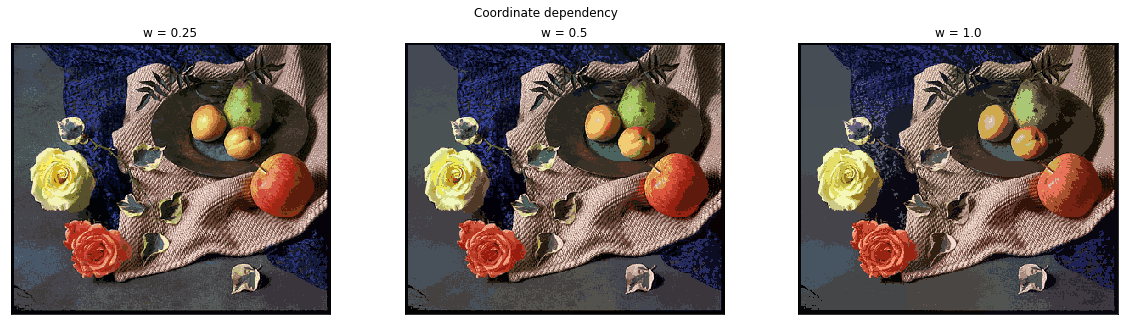

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Coordinate dependency')
for i, weight in enumerate([0.25, 0.50, 1.0]):
    _, (w, h, _), image_array = load_image('Fruit.jpg', w=weight, coordinate_dependency=True)
    codebook, labels = cluster_colors(image_array, 'kmeans', 64)
    recreated = recreate_image(codebook[:, :3], labels, w, h)
    axes[i].imshow(recreated)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title('w = {}'.format(weight))
plt.show()

When comparing the above images with recreated images using just color homogeneity, we can see that the colors used for each object is locally obtained. That is, the color of red in the rose is different from color of red from apple. But when clustered using just color homogeneity, the color on the apple and rose in the recreated image were the same. As we increase the value `w`, i.e., the weight of region connectivity, we can see the image tends to get smoother with respect to the coloring. But, with a high value of `w`, we tend to see a small bleeding effect. For example, the image where `w = 1.0`, we can see the pear fruit has been recreated with yellow from the fruits around it instead of the green, which is the original color of the pear. We can also see the same effect on the bottom edge of the yellow rose where it has been applied the color from the floor on which it was placed on.